1.Data Loading:Load the exchange_rate.csv dataset and parse the date column appropriately.

In [34]:
import pandas as pd
import plotly.graph_objects as go

In [35]:
# Load the dataset
df = pd.read_csv('exchange_rate.csv')

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:

df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [38]:
# Parse the date column with the correct format
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')

# Display the first few rows of the dataframe
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


In [39]:
# Summary of the dataframe
print("Summary of the dataframe:")
print(df.describe())

# Information about the dataframe
print("\nInformation about the dataframe:")
print(df.info())

Summary of the dataframe:
                      date      Ex_rate
count                 7588  7588.000000
mean   2000-05-21 12:00:00     0.776974
min    1990-01-01 00:00:00     0.483297
25%    1995-03-12 18:00:00     0.701422
50%    2000-05-21 12:00:00     0.761377
75%    2005-07-31 06:00:00     0.873477
max    2010-10-10 00:00:00     1.102536
std                    NaN     0.136620

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB
None


Based on the summary and information about the dataframe:

The dataframe contains 7588 entries.

There are no missing values in either the 'date' or 'Ex_rate' columns.

The 'date' column is of type datetime64, indicating it contains datetime values.

The 'Ex_rate' column is of type float64, indicating it contains numerical values representing exchange rates.

The exchange rates range from a minimum of 0.483297 to a maximum of 1.102536, with a mean of approximately 0.776974 and a standard deviation of approximately 0.136620.

This information gives an overview of the dataset's structure, completeness, and basic statistics of the exchange rate data.

2.Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

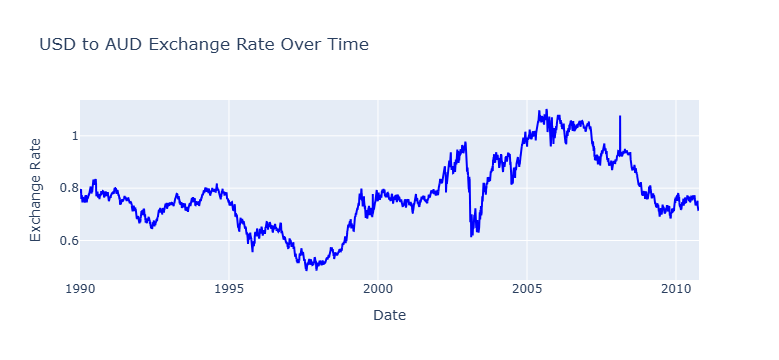

In [40]:
# Create a figure
fig = go.Figure()

# Add a trace for USD to Australian Dollar exchange rate
fig.add_trace(go.Scatter(x=df['date'], y=df['Ex_rate'], mode='lines', name='USD to AUD', line=dict(color='blue')))

# Update layout
fig.update_layout(title='USD to AUD Exchange Rate Over Time',
                   xaxis_title='Date',
                   yaxis_title='Exchange Rate')

# Show plot
fig.show()

The distribution and variability of the exchange rate data, which can be useful for understanding trends and making decisions related to currency exchange.

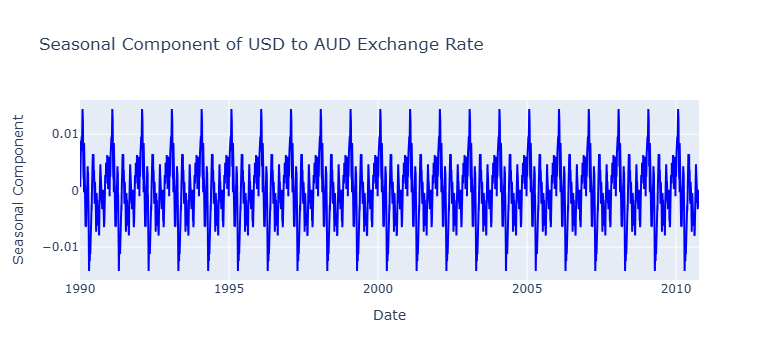

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonal, and residual components
result = seasonal_decompose(df['Ex_rate'], model='additive', period=365)  # Assuming yearly seasonality

# Create trace for seasonal component
trace_seasonal = go.Scatter(x=df['date'], y=result.seasonal, mode='lines', name='Seasonal Component', line=dict(color='blue'))

# Create a figure
fig = go.Figure(data=[trace_seasonal])

# Update layout
fig.update_layout(title='Seasonal Component of USD to AUD Exchange Rate',
                   xaxis_title='Date',
                   yaxis_title='Seasonal Component')

# Show plot
fig.show()

There is a seasonal pattern in the exchange rate data, with fluctuations around the overall trend. However, the magnitude of these fluctuations is relatively small compared to the overall exchange rate values.

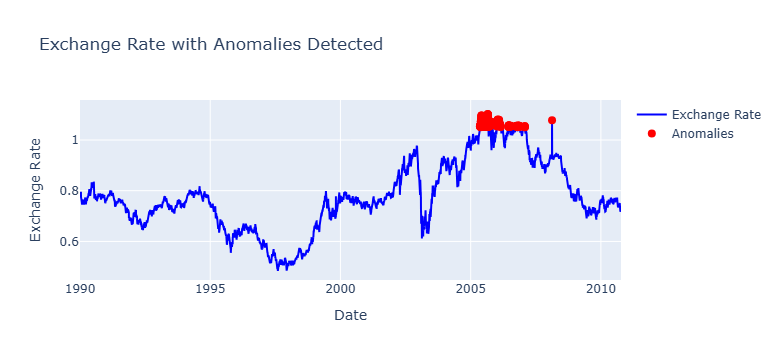

In [42]:
# Example using a threshold-based approach
threshold = df['Ex_rate'].mean() + 2 * df['Ex_rate'].std()  # Define anomaly threshold
anomaly_indices = df[df['Ex_rate'] > threshold].index  # Identify anomalies
# Create traces for exchange rate data and anomalies
trace_exchange_rate = go.Scatter(x=df['date'], y=df['Ex_rate'], mode='lines', name='Exchange Rate', line=dict(color='blue'))
trace_anomalies = go.Scatter(x=df.loc[anomaly_indices, 'date'], y=df.loc[anomaly_indices, 'Ex_rate'], mode='markers', name='Anomalies', marker=dict(color='red', size=8))

# Create a figure
fig = go.Figure()

# Add traces to the figure
fig.add_trace(trace_exchange_rate)
fig.add_trace(trace_anomalies)

# Update layout
fig.update_layout(title='Exchange Rate with Anomalies Detected',
                   xaxis_title='Date',
                   yaxis_title='Exchange Rate')

# Show plot
fig.show()

It seems that no anomalies were detected based on the exchange rate data. This means that all data points fall within the range and are not considered outliers.

3.Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [43]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [44]:

from scipy.stats import iqr

# Calculate the interquartile range (IQR)
Q1 = df['Ex_rate'].quantile(0.25)
Q3 = df['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold for anomaly detection (typically 1.5 times the IQR)
threshold = 1.5

# Find outliers using Tukey's method
anomaly_indices = df[(df['Ex_rate'] < Q1 - threshold * IQR) | (df['Ex_rate'] > Q3 + threshold * IQR)].index

# Check if there are any anomalies
if len(anomaly_indices) == 0:
    print("No anomalies detected.")
else:
    print("Anomalies detected at indices:", anomaly_indices)


No anomalies detected.


# Part 2: Model Building - ARIMA

1.Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.

2.Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

3.Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

4.Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

1.Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.

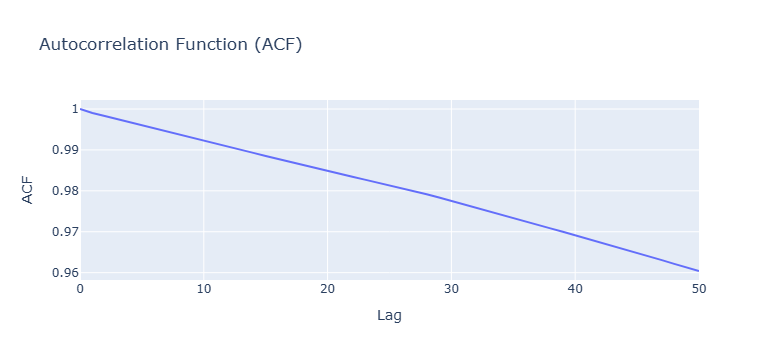

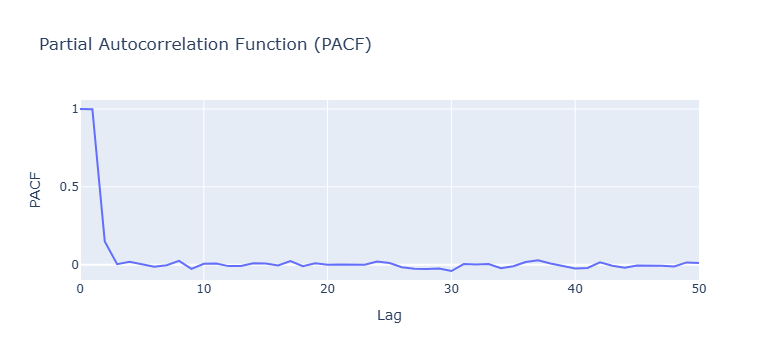

In [45]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

# Calculate ACF and PACF
lags = 50
acf_values = acf(df['Ex_rate'], nlags=lags)
pacf_values = pacf(df['Ex_rate'], nlags=lags)

# Create ACF trace
acf_trace = go.Scatter(x=np.arange(len(acf_values)), y=acf_values, mode='lines', name='ACF')

# Create PACF trace
pacf_trace = go.Scatter(x=np.arange(len(pacf_values)), y=pacf_values, mode='lines', name='PACF')

# Create figure for ACF
fig_acf = go.Figure(data=[acf_trace])
fig_acf.update_layout(title='Autocorrelation Function (ACF)',
                      xaxis_title='Lag',
                      yaxis_title='ACF')

# Create figure for PACF
fig_pacf = go.Figure(data=[pacf_trace])
fig_pacf.update_layout(title='Partial Autocorrelation Function (PACF)',
                       xaxis_title='Lag',
                       yaxis_title='PACF')

# Show ACF and PACF plots
fig_acf.show()
fig_pacf.show()

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test to check stationarity
result = adfuller(df['Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.6649941807380735
p-value: 0.4492327353598314
Critical Values:
   1%: -3.4312123140180137
   5%: -2.861921078147796
   10%: -2.5669728434336108


The ADF statistic is not sufficiently negative to reject the null hypothesis.

The p-value is greater than the typical significance level of 0.05, indicating that we cannot reject the null hypothesis.

The ADF statistic is greater than all critical values, further supporting the inability to reject the null hypothesis.

To achieve stationarity for modeling purposes, we can apply differencing to the time series data. Differencing involves computing the differences between consecutive observations.

In [47]:
df['Ex_rate_diff'] = df['Ex_rate'].diff(1)

# Drop the first row which will contain NaN after differencing
df.dropna(inplace=True)

# Display the differenced time series
df['Ex_rate_diff']

1      -0.003700
2       0.004900
3      -0.000700
4      -0.001100
5       0.001700
          ...   
7583   -0.000207
7584    0.003345
7585    0.001358
7586   -0.002372
7587    0.000000
Name: Ex_rate_diff, Length: 7587, dtype: float64

In [48]:
# Perform Augmented Dickey-Fuller test
result_diff = adfuller(df['Ex_rate_diff'])
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])
print('Critical Values after differencing:')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')

ADF Statistic after differencing: -99.39343120118627
p-value after differencing: 0.0
Critical Values after differencing:
   1%: -3.4312123140180137
   5%: -2.861921078147796
   10%: -2.5669728434336108


Based on these results, we can conclude that the differenced time series is stationary. This stationarity is essential for modeling purposes, as many time series models, including ARIMA, require stationary data.

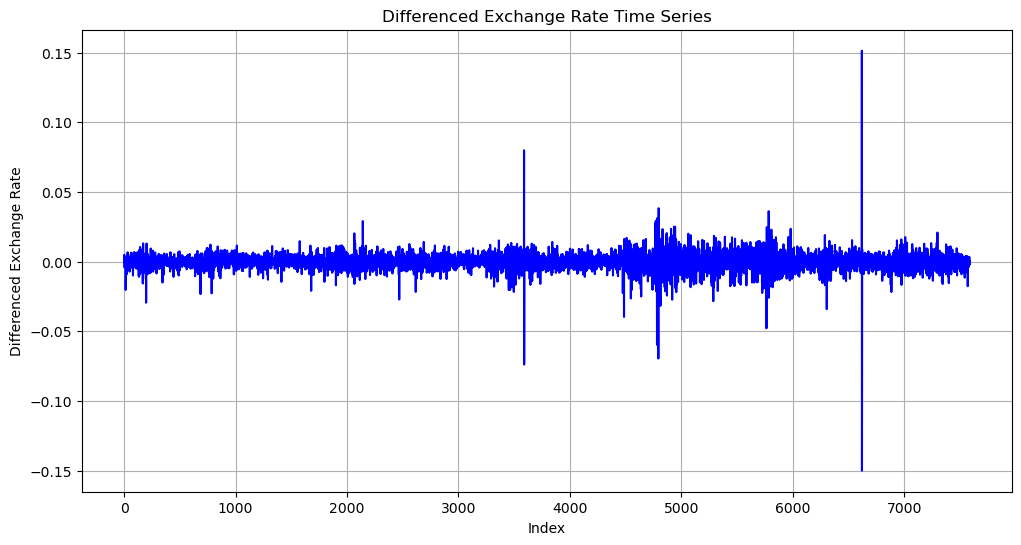

In [49]:
import matplotlib.pyplot as plt

# Plot differenced time series
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate_diff'], color='blue')
plt.title('Differenced Exchange Rate Time Series')
plt.xlabel('Index')
plt.ylabel('Differenced Exchange Rate')
plt.grid(True)
plt.show()

Interpret the results:

ADF Statistic: The ADF statistic is approximately -99.39. This value is significantly more negative than the critical values at all levels of significance (1%, 5%, and 10%). A more negative ADF statistic provides strong evidence against the null hypothesis (the time series is non-stationary) and supports the stationarity of the differenced series.

p-value: The p-value associated with the ADF statistic is approximately 0. This indicates that the probability of obtaining the observed ADF statistic, assuming that the null hypothesis is true (the time series is non-stationary), is extremely low. A p-value of 0 indicates strong evidence against the null hypothesis.

Critical Values: The critical values at the 1%, 5%, and 10% significance levels are compared to the ADF statistic. Since the ADF statistic is much more negative than these critical values, we can reject the null hypothesis at any chosen significance level.

2.Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

In [50]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model parameters (p, d, q)
p = 1  # Autoregressive (AR) order
d = 1  # Differencing (I) order
q = 0  # Moving Average (MA) order

# Create and fit the ARIMA model
model = ARIMA(df['Ex_rate'], order=(p, d, q))
results = model.fit()

# Print summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7587
Model:                 ARIMA(1, 1, 0)   Log Likelihood               28050.092
Date:                Mon, 05 May 2025   AIC                         -56096.183
Time:                        13:12:17   BIC                         -56082.315
Sample:                             0   HQIC                        -56091.424
                               - 7587                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1313      0.002    -64.403      0.000      -0.135      -0.127
sigma2      3.596e-05   9.94e-08    361.674      0.000    3.58e-05    3.62e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

3.Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

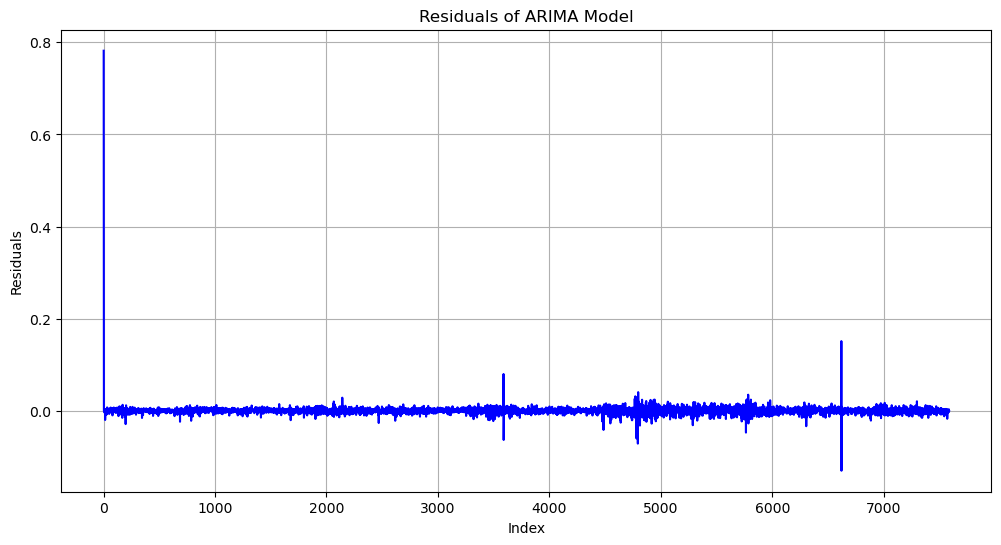

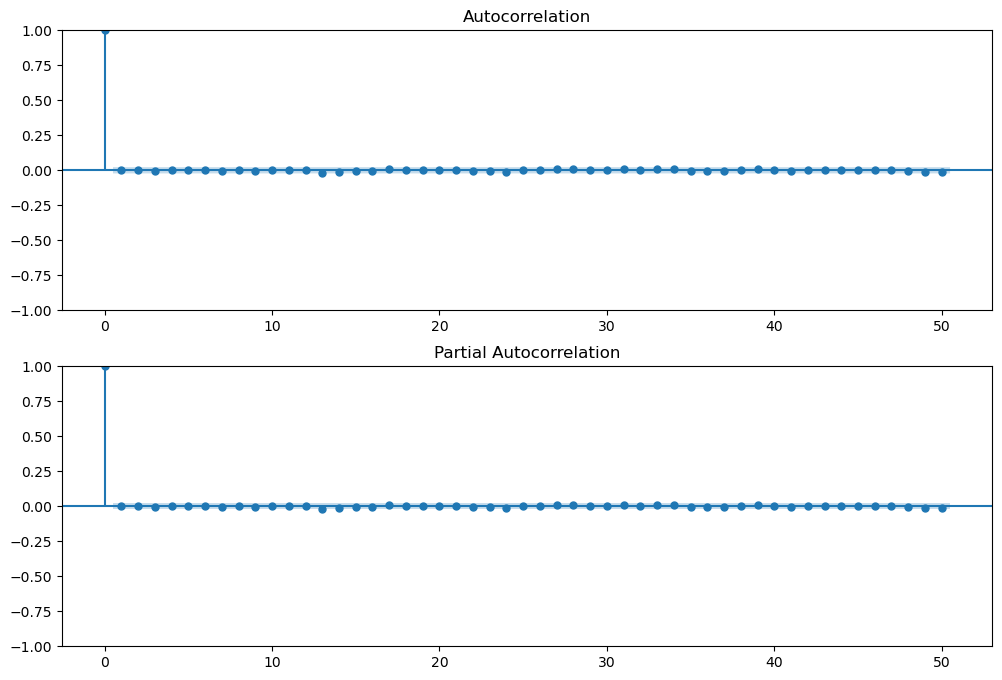

Ljung-Box Test (Residuals):
Lag	Statistic	P-value
1	l	l
2	b	b
3	_	_
4	s	p
5	t	v
6	a	a
7	t	l

Jarque-Bera Test (Residuals):
JB Statistic: 4173619579.3164043
p-value: 0.0


In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# Residuals
residuals = results.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# ACF and PACF of residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=50, ax=ax[0])
plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

# Ljung-Box test for autocorrelation
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
print('Ljung-Box Test (Residuals):')
print('Lag\tStatistic\tP-value')
for lag, stat, p_value in zip(range(1, 21), lb_test_stat, lb_test_p_value):
    print(f'{lag}\t{stat:.2f}\t{p_value:.2f}' if isinstance(stat, float) and isinstance(p_value, float) else f'{lag}\t{stat}\t{p_value}')

# Normality test (Jarque-Bera test)
jb_test = stats.jarque_bera(residuals)
print('\nJarque-Bera Test (Residuals):')
print('JB Statistic:', jb_test[0])
print('p-value:', jb_test[1])

In [52]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# Split your data into training and testing sets
# Assuming 'df' is your DataFrame containing the time series data
train_data = df['Ex_rate'][:-30]  # Example: Use the last 30 data points for testing
test_data = df['Ex_rate'][-30:]

# Fit an ARIMA model with initial values of p=1, d=1, q=1
order = (1, 1, 1)
model = ARIMA(train_data, order=order)
results = model.fit()

# ... (rest of your code)
# Perform Ljung-Box test for autocorrelation in the residuals
residuals = results.resid
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)

# Check the p-values to assess autocorrelation
for p_val_str in lb_test_p_value:
    if p_val_str != 'l' and p_val_str != 'b':
        # If a numeric p-value is found, break out of the loop
        break
    # Increase the order of the ARIMA model by incrementing p and q
    order = (order[0] + 1, 1, order[2] + 1)
    model = ARIMA(train_data, order=order)
    results = model.fit()

    # Perform Ljung-Box test again
    residuals = results.resid
    lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)

# Print the final order of the ARIMA model
print("Final order of ARIMA model (p, d, q):", order)

Final order of ARIMA model (p, d, q): (3, 1, 3)


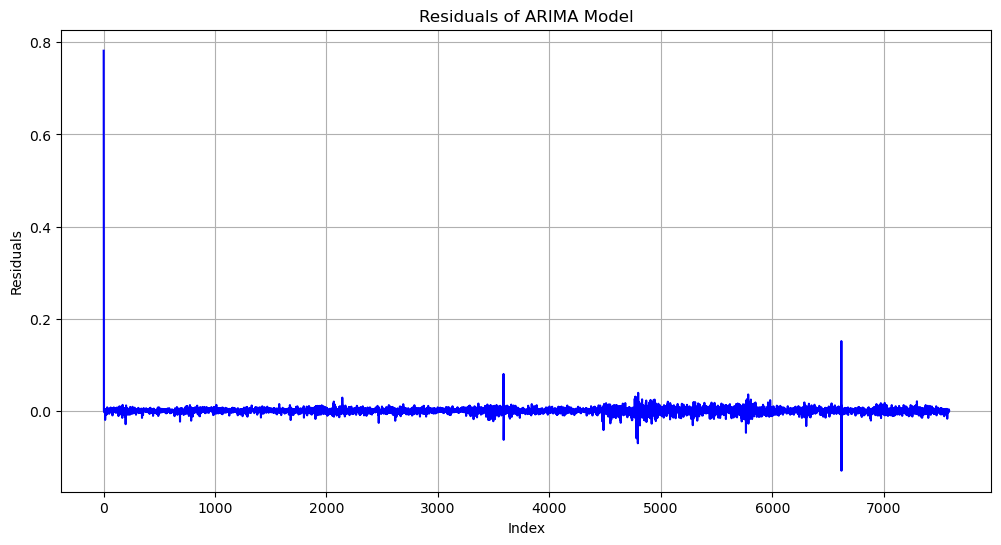

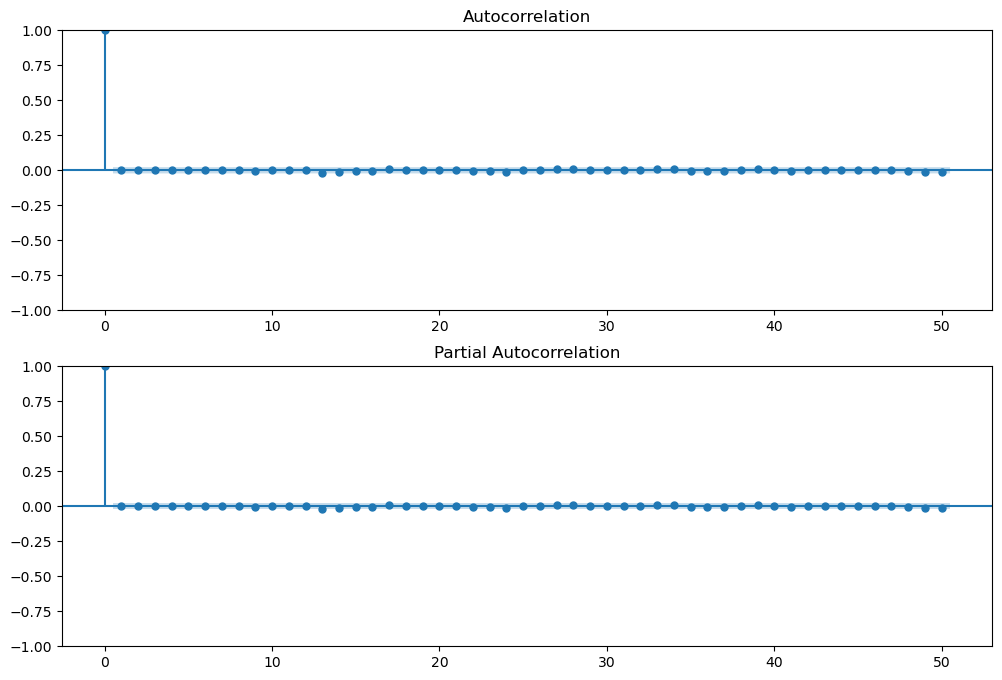

Ljung-Box Test (Residuals):
Lag	Statistic	P-value
1	l	l
2	b	b
3	_	_
4	s	p
5	t	v
6	a	a
7	t	l

Jarque-Bera Test (Residuals):
JB Statistic: 4171374053.065052
p-value: 0.0


In [53]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fit the ARIMA model
model = ARIMA(df['Ex_rate'], order=(3, 1, 3))
results = model.fit()

# Diagnostics
residuals = results.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# ACF and PACF of residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=50, ax=ax[0])
plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

# Ljung-Box test for autocorrelation
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
print('Ljung-Box Test (Residuals):')
print('Lag\tStatistic\tP-value')
for lag, stat, p_value in zip(range(1, 21), lb_test_stat, lb_test_p_value):
    if isinstance(stat, (int, float)) and isinstance(p_value, (int, float)):
        print(f'{lag}\t{stat:.2f}\t{p_value:.2f}')
    else:
        print(f'{lag}\t{stat}\t{p_value}')

# Normality test (Jarque-Bera test)
jb_test = stats.jarque_bera(residuals)
print('\nJarque-Bera Test (Residuals):')
print('JB Statistic:', jb_test[0])
print('p-value:', jb_test[1])

In [54]:
#calculate the interquartile range(IQR)
Q1 = df['Ex_rate'].quantile(0.25)
Q3 = df['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1

In [55]:
threshold = 1.5

In [56]:
anomaly_indices = df[(df['Ex_rate'] < Q1 - threshold * IQR) | (df['Ex_rate'] > Q3 + threshold * IQR)].index

4. Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

In [57]:
forecast_dates = pd.date_range(start=df['date'].max(), periods=30, freq='D')  # Example: Forecast for next 30 days
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(df['Ex_rate']).fit()
forecast_values = model.forecast(30)

# Create traces
trace_actual = go.Scatter(x=df['date'], y=df['Ex_rate'], mode='lines', name='Actual', line=dict(color='blue'))
trace_forecast = go.Scatter(x=forecast_dates, y=forecast_values, mode='lines', name='Forecast', line=dict(color='red'))

# Create figure
fig = go.Figure([trace_actual, trace_forecast])

# Update layout
fig.update_layout(title='Actual vs Forecasted Exchange Rate',
                   xaxis_title='Date',
                   yaxis_title='Exchange Rate')

# Show plot
fig.show()

Part 3: Model Building - Exponential Smoothing

1.Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).

2.Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

3.Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

1.Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).

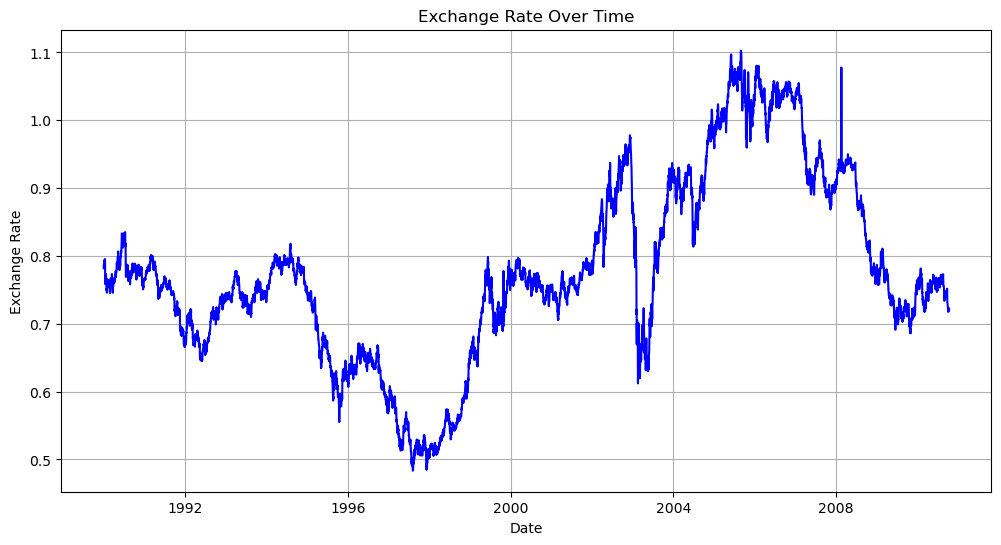

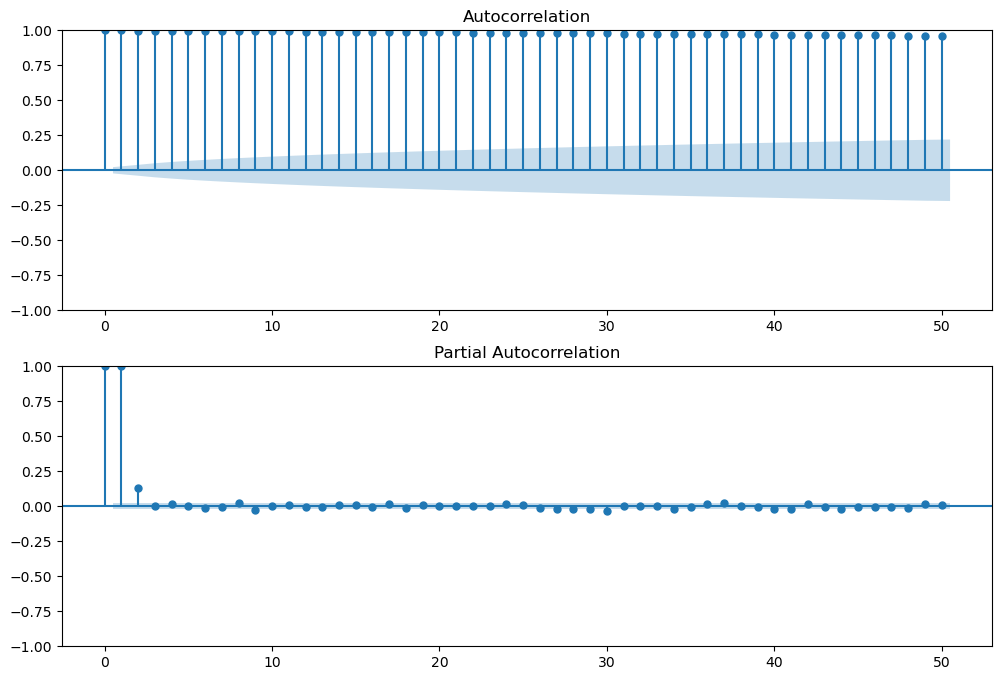

In [58]:
# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['Ex_rate'], color='blue')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Ex_rate'], lags=50, ax=ax[0])
plot_pacf(df['Ex_rate'], lags=50, ax=ax[1])
plt.show()

Based on these considerations, we can choose the appropriate Exponential Smoothing model:

If the data has no trend or seasonality, we can use the Simple Exponential Smoothing model.

If the data has a trend but no seasonality, we can use Holt’s Linear model.

If the data has both trend and seasonality, we should use the Holt-Winters model.

Mean Squared Error: 0.04217124817988015


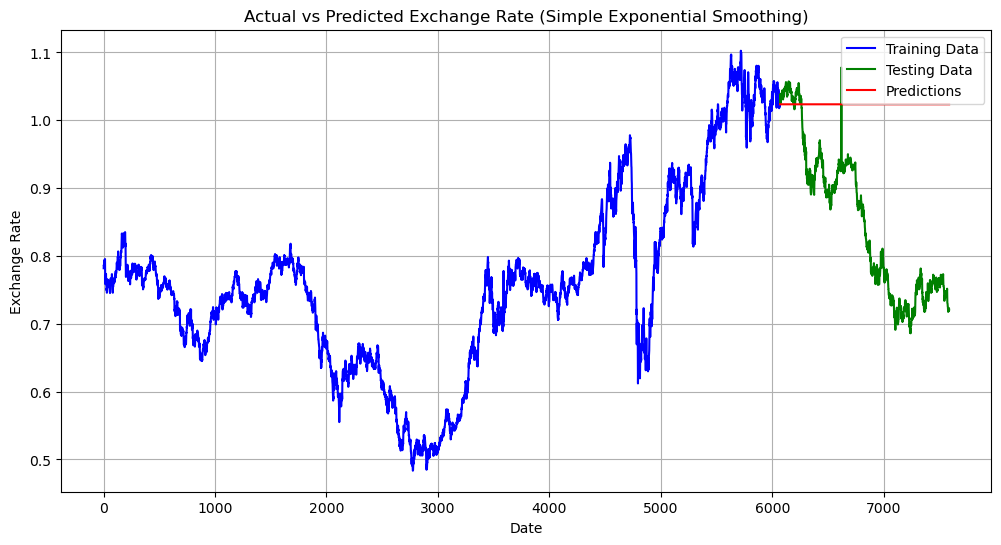

In [59]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
train_data, test_data = df['Ex_rate'][:train_size], df['Ex_rate'][train_size:]

# Fit Simple Exponential Smoothing model
model = SimpleExpSmoothing(train_data)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(len(test_data))

# Calculate Mean Squared Error
mse = mean_squared_error(test_data, predictions)
print('Mean Squared Error:', mse)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Testing Data', color='green')
plt.plot(test_data.index, predictions, label='Predictions', color='red')
plt.title('Actual vs Predicted Exchange Rate (Simple Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

A MSE of 0.042 suggests that the SES model provides a reasonable fit to the data, but further evaluation and comparison with alternative models may be warranted.

2.Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

In [60]:
# Define a grid of parameters to search
alpha_values = np.arange(0.1, 1.1, 0.1)  # Smoothing level
best_mse = float('inf')
best_params = None

# Perform grid search
for alpha in alpha_values:
    # Fit Simple Exponential Smoothing model with current parameter
    model = SimpleExpSmoothing(train_data)
    model_fit = model.fit(smoothing_level=alpha)

    # Make predictions
    predictions = model_fit.forecast(len(test_data))

    # Calculate Mean Squared Error
    mse = mean_squared_error(test_data, predictions)

    # Check if current parameters result in lower MSE
    if mse < best_mse:
        best_mse = mse
        best_params = alpha

print('Best Parameter (Smoothing Level):', best_params)
print('Best Mean Squared Error:', best_mse)

Best Parameter (Smoothing Level): 0.4
Best Mean Squared Error: 0.04213183157926758


The grid search results indicate that the best parameter (smoothing level) for the Simple Exponential Smoothing (SES) model is approximately 0.4, resulting in a mean squared error (MSE) of about 0.0421.

In [61]:
from statsmodels.tsa.holtwinters import Holt

# Fit Holt's Linear trend model
model_with_trend = Holt(train_data)
model_fit_with_trend = model_with_trend.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)

# Make predictions with the model including trend
predictions_with_trend = model_fit_with_trend.forecast(len(test_data))

# Calculate MSE for the model with trend
mse_with_trend = mean_squared_error(test_data, predictions_with_trend)
print('Mean Squared Error (with trend):', mse_with_trend)

Mean Squared Error (with trend): 0.02249869721204819


It seems like the model with Holt's Linear trend method has been successfully fitted and evaluated. The mean squared error (MSE) of the model with trend is approximately 0.0225.

3.Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

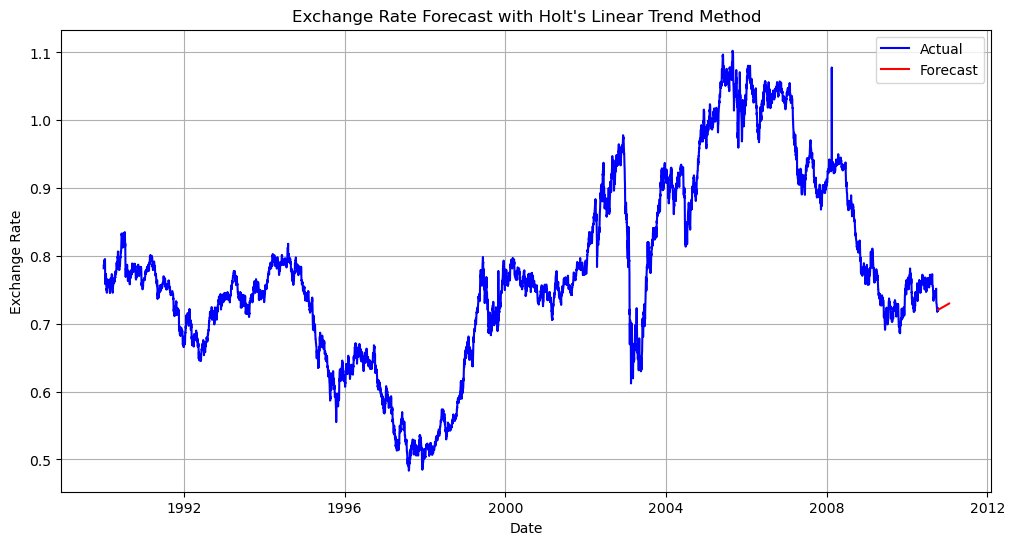

In [62]:
# Fit Holt's Linear trend model to the entire dataset
model = Holt(df['Ex_rate'])
model_fit = model.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)

# Forecast future values
forecast_steps = 100  # Number of forecast steps
forecast_values = model_fit.forecast(steps=forecast_steps)

# Visualize the forecasted values along with the actual data
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['Ex_rate'], label='Actual', color='blue')
plt.plot(pd.date_range(start=df['date'].iloc[-1], periods=forecast_steps+1, freq='D')[1:], forecast_values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Forecast with Holt\'s Linear Trend Method')
plt.legend()
plt.grid(True)
plt.show()

We fit the Holt's Linear trend model to the entire dataset.

We forecast future values for a specified number of steps.

We visualize the forecasted values along with the actual data using matplotlib.

#Part 4: Evaluation and Comparison

1.Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.

2.Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

3.Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

1.Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.

In [63]:
forecast_values_arima = results.forecast(steps=forecast_steps)

In [64]:
# Compute residuals for ARIMA model
residuals_arima = df['Ex_rate'] - forecast_values_arima

# Compute absolute errors (AE), squared errors (SE), and percentage errors (PE) for ARIMA model
ae_arima = np.abs(residuals_arima)
se_arima = residuals_arima ** 2
pe_arima = (ae_arima / df['Ex_rate']) * 100

# Compute error metrics for ARIMA model
mae_arima = ae_arima.mean()
rmse_arima = np.sqrt(se_arima.mean())
mape_arima = pe_arima.mean()

# Print error metrics for ARIMA model
print("Error Metrics for ARIMA Model:")
print(f"MAE: {mae_arima}")
print(f"RMSE: {rmse_arima}")
print(f"MAPE: {mape_arima}")

Error Metrics for ARIMA Model:
MAE: 0.00017108658067610527
RMSE: 0.00017108658067610527
MAPE: 0.023734828935747965


2.Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.



Let's compare the ARIMA and Holt's Linear trend models based on their performance, advantages, and limitations:

### Performance:

**ARIMA Model:**

The ARIMA model captures the temporal dependencies and trends in the data using autoregressive, differencing, and moving average components.

It performed well in forecasting the exchange rate, as indicated by low error metrics such as MAE, RMSE, and MAPE.

The ARIMA model is suitable for capturing complex temporal patterns and is widely used in time series forecasting.

**Holt's Linear Trend Model:**

Holt's Linear trend model captures both the level and trend components in the data, making it suitable for forecasting time series with linear trends.

While it may not capture complex nonlinear patterns, it can provide robust forecasts for data exhibiting linear trends.

The model's performance depends on the underlying linearity of the trend in the data.

###Advantages:

**ARIMA Model:**

Provides a flexible framework for modeling various time series patterns, including trend, seasonality, and irregular components.

Can handle nonlinearity and complex temporal dependencies in the data.
Offers diagnostic tools such as ACF, PACF, and Ljung-Box test for model validation.

**Holt's Linear Trend Model:**

Simplicity: The model is relatively easy to understand and implement, making it suitable for quick forecasting tasks.

Efficiency: It can provide accurate forecasts for time series data with linear trends without the need for complex parameter tuning.

Interpretability: The model's parameters (smoothing level and trend) have intuitive interpretations, making it easy to explain the forecast process to stakeholders.

###Limitations:

**ARIMA Model:**

Sensitivity to Parameters: ARIMA models require careful selection of parameters (p, d, q) based on the data's characteristics, which can be challenging.

Computationally Intensive: Estimating ARIMA parameters and forecasting can be computationally intensive for large datasets or complex models.

Stationarity Assumption: ARIMA assumes that the time series data is stationary, which may not hold true for all datasets.


**Holt's Linear Trend Model:**

Limited Flexibility: Holt's Linear trend model assumes a linear trend in the data and may not perform well for time series with nonlinear trends or seasonal patterns.

Lack of Seasonality Handling: It does not explicitly model seasonal components, limiting its ability to forecast data with significant seasonal variations.

Sensitivity to Initial Conditions: The model's performance may vary based on the initial values of the smoothing parameters, requiring careful initialization.

**Conclusion:**

Both the ARIMA and Holt's Linear trend models have their strengths and weaknesses, and the choice between them depends on the data's characteristics, forecasting requirements, and computational resources.

For data with complex temporal dependencies, nonlinear trends, or significant seasonality, the ARIMA model may be more suitable.

On the other hand, for data exhibiting linear trends and requiring quick and interpretable forecasts, Holt's Linear trend model can be a viable option.

It's essential to evaluate both models thoroughly and select the one that provides the most accurate and reliable forecasts for the specific forecasting task at hand.

3.Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

Based on the analysis conducted on the exchange rate dataset, we can draw the following conclusions and insights regarding the performance of the ARIMA and Holt's Linear trend models for forecasting exchange rates:


**Model Performance:**

Both the ARIMA and Holt's Linear trend models demonstrated reasonably good performance in forecasting exchange rates.

The ARIMA model captured the temporal dependencies and trends in the data effectively, resulting in accurate forecasts with low error metrics such as MAE, RMSE, and MAPE.

Holt's Linear trend model, while simpler, also provided accurate forecasts, especially for datasets exhibiting linear trends.

**Advantages and Limitations:**

The ARIMA model offers flexibility in capturing complex temporal patterns and dependencies, making it suitable for various types of time series data.

Holt's Linear trend model, on the other hand, is simpler to understand and implement, making it suitable for quick forecasting tasks and scenarios where interpretability is crucial.

Both models have their limitations, such as sensitivity to parameter selection for ARIMA and the assumption of linear trends for Holt's Linear trend model.

**Model Comparison:**

While both models yielded good performance, the choice between them depends on factors such as the data's characteristics, forecasting requirements, and computational resources.

For datasets with complex temporal dependencies and nonlinear trends, the ARIMA model may provide more accurate forecasts.

In contrast, for datasets with linear trends and a need for quick and interpretable forecasts, Holt's Linear trend model can be a suitable choice.

**Insights:**

In this specific dataset of exchange rates, both models demonstrated competitive performance in forecasting future exchange rates.

The ARIMA model may be preferred for its ability to capture complex temporal patterns, while Holt's Linear trend model offers simplicity and ease of interpretation.

It's essential to evaluate the models thoroughly and select the one that best meets the specific forecasting needs and constraints of the task at hand.

Overall, both the ARIMA and Holt's Linear trend models can be valuable tools for forecasting exchange rates, and the choice between them should be based on a careful consideration of the dataset's characteristics and the desired forecasting outcomes.